# <span style="border:1px solid blue;background-color:yellow;color:blue;font-family:Courier;font-size:1.0em"> Inicio </span>

## Links uteis 

- Cores em graficos plotly: https://plotly.com/python/discrete-color/
- https://www.selecolor.com/en/recommended-color-palette/

## Importação de libs

In [2]:
# para ler arquivo excel (xls)
# conda install -c anaconda xlrd

import datetime
from datetime import datetime
import os

# Analise
import pandas as pd 
import numpy as np 

#Visualization
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import plotly
import plotly.express as px

## Configurações

In [3]:
# para habilitar rolagem horizontal do dataframe 
# caso não funcione no Firefox
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [4]:
# formatação de mensagens de print
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
#print(color.BOLD + 'Hello World !' + color.END)

## Parâmetros

In [5]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos

np.set_printoptions(threshold=1000)

# Formatar numeros float (2 casas decimais)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# Formatações para gráficos
sns.set(style="darkgrid") #cor da area dos plots
figsize = (10,10)

carga dos dados das ies federais já filtradas e com os dados do IBGE- gerado pela renata

In [37]:
list_col_string = ['CO_IES'] 
dict_dtype = {column : 'str'  for column in list_col_string}

ies = pd.read_csv('../arquivos/dados_ies_consolidado.csv', sep ='|',
                  dtype = dict_dtype, low_memory=False)
ies = ies[['CO_IES', 'NO_IES', 'SG_IES' ]]
ies.head()


,CO_IES,NO_IES,SG_IES
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,UFMT
1,780,UNIVERSIDADE DE CUIABÁ,UNIC/UNIME
2,1233,CENTRO UNIVERSITÁRIO UNIC,NaN
3,1941,FACULDADE CUIABÁ,FAUC
4,1996,INSTITUTO CUIABÁ DE ENSINO E CULTURA,ICEC


Carga dos cursos de 2022 e filtro para pegar só as federais     

In [24]:
%%time

# definir os tipos de algumas colunas 
# facilita operações de merge (tem que conter os mesmos tipos de dados)
list_col_string = ['CO_REGIAO', 'CO_UF', 'CO_MUNICIPIO', 'CO_CURSO', 'CO_CINE_ROTULO',
                   'CO_CINE_AREA_GERAL','CO_CINE_AREA_ESPECIFICA','CO_CINE_AREA_DETALHADA','CO_IES'] 
dict_dtype = {column : 'str'  for column in list_col_string}

df_cursos = pd.read_csv('../arquivos/MICRODADOS_CADASTRO_CURSOS_2022.CSV', 
                          dtype = dict_dtype,
                          sep=';',
                          encoding='iso-8859-1',
                          low_memory=False)

df_cursos = df_cursos.drop(['TP_DIMENSAO','TP_CATEGORIA_ADMINISTRATIVA','TP_REDE', 'IN_GRATUITO',\
                            'QT_ING_FINANC','QT_ING_FINANC_REEMB','QT_ING_FIES','QT_ING_RPFIES','QT_ING_FINANC_REEMB_OUTROS','QT_ING_FINANC_NREEMB','QT_ING_PROUNII','QT_ING_PROUNIP',\
                            'QT_ING_NRPFIES','QT_ING_FINANC_NREEMB_OUTROS','QT_MAT_FINANC','QT_MAT_FINANC_REEMB','QT_MAT_FIES','QT_MAT_RPFIES','QT_MAT_FINANC_REEMB_OUTROS','QT_MAT_FINANC_NREEMB','QT_MAT_PROUNII','QT_MAT_PROUNIP',\
                            'QT_MAT_NRPFIES','QT_MAT_FINANC_NREEMB_OUTROS','QT_CONC_FINANC','QT_CONC_FINANC_REEMB','QT_CONC_FIES','QT_CONC_RPFIES','QT_CONC_FINANC_REEMB_OUTROS','QT_CONC_FINANC_NREEMB','QT_CONC_PROUNII',	\
                            'QT_CONC_PROUNIP','QT_CONC_NRPFIES','QT_CONC_FINANC_NREEMB_OUTROS'  ], axis=1)



CPU times: total: 16.1 s
Wall time: 34.1 s


cidades com Micro regiões IBGE - e populacao

In [25]:
list_col_string = ['codigo_ibge', ] 
dict_dtype = {column : 'str'  for column in list_col_string}

df_micro_reg = pd.read_csv('../arquivos/cidades_estados.CSV', 
                          dtype = dict_dtype,
                          low_memory=False)

df_micro_reg = df_micro_reg[['codigo_ibge', 'latitude_cidade','longitude_cidade','POPULACAO','uf','nome_estado',\
                             'regiao', 'CO_REGIAO_INTERMEDIARIA', 'CO_REGIAO_IMEDIATA', 'CO_MESORREGIAO', 'CO_MICRORREGIAO','NO_REGIAO_INTERMEDIARIA', 'NO_REGIAO_IMEDIATA', 'NO_MESORREGIAO', 'NO_MICRORREGIAO']]

df_micro_reg.head()

,codigo_ibge,latitude_cidade,longitude_cidade,POPULACAO,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,CO_REGIAO_IMEDIATA,CO_MESORREGIAO,CO_MICRORREGIAO,NO_REGIAO_INTERMEDIARIA,NO_REGIAO_IMEDIATA,NO_MESORREGIAO,NO_MICRORREGIAO
0,5200050,-16.76,-49.44,5324826,GO,Goiás,Centro-Oeste,5201,520001,3,10,Goiânia,Goiânia,Centro Goiano,Goiânia
1,5200100,-16.20,-48.71,5325826,GO,Goiás,Centro-Oeste,5201,520002,4,12,Goiânia,Anápolis,Leste Goiano,Entorno de Brasília
2,5200134,-17.40,-50.37,5326826,GO,Goiás,Centro-Oeste,5204,520015,5,14,São Luís de Montes Belos - Iporá,Palmeiras de Goiás,Sul Goiano,Vale do Rio dos Bois
3,5200159,-16.41,-50.17,5327826,GO,Goiás,Centro-Oeste,5201,520003,3,9,Goiânia,Inhumas - Itaberaí - Anicuns,Centro Goiano,Anicuns
4,5200175,-14.98,-47.78,5328826,GO,Goiás,Centro-Oeste,5206,520022,4,12,Luziânia - Águas Lindas de Goiás,Flores de Goiás,Leste Goiano,Entorno de Brasília


juntar cursos com ies 


In [26]:
df_cursos_ies_ibge = df_cursos.merge(ies, how= 'inner', left_on='CO_IES', right_on='CO_IES')
df_cursos_ies_ibge.head()

,NU_ANO_CENSO,NO_REGIAO,CO_REGIAO,NO_UF,SG_UF,CO_UF,NO_MUNICIPIO,CO_MUNICIPIO,IN_CAPITAL,TP_ORGANIZACAO_ACADEMICA,CO_IES,NO_CURSO,CO_CURSO,NO_CINE_ROTULO,CO_CINE_ROTULO,CO_CINE_AREA_GERAL,NO_CINE_AREA_GERAL,CO_CINE_AREA_ESPECIFICA,NO_CINE_AREA_ESPECIFICA,CO_CINE_AREA_DETALHADA,NO_CINE_AREA_DETALHADA,TP_GRAU_ACADEMICO,TP_MODALIDADE_ENSINO,TP_NIVEL_ACADEMICO,QT_CURSO,QT_VG_TOTAL,QT_VG_TOTAL_DIURNO,QT_VG_TOTAL_NOTURNO,QT_VG_TOTAL_EAD,QT_VG_NOVA,QT_VG_PROC_SELETIVO,QT_VG_REMANESC,QT_VG_PROG_ESPECIAL,QT_INSCRITO_TOTAL,QT_INSCRITO_TOTAL_DIURNO,QT_INSCRITO_TOTAL_NOTURNO,QT_INSCRITO_TOTAL_EAD,QT_INSC_VG_NOVA,QT_INSC_PROC_SELETIVO,QT_INSC_VG_REMANESC,QT_INSC_VG_PROG_ESPECIAL,QT_ING,QT_ING_FEM,QT_ING_MASC,QT_ING_DIURNO,QT_ING_NOTURNO,QT_ING_VG_NOVA,QT_ING_VESTIBULAR,QT_ING_ENEM,QT_ING_AVALIACAO_SERIADA,QT_ING_SELECAO_SIMPLIFICA,QT_ING_EGR,QT_ING_OUTRO_TIPO_SELECAO,QT_ING_PROC_SELETIVO,QT_ING_VG_REMANESC,QT_ING_VG_PROG_ESPECIAL,QT_ING_OUTRA_FORMA,QT_ING_0_17,QT_ING_18_24,QT_ING_25_29,QT_ING_30_34,QT_ING_35_39,QT_ING_40_49,QT_ING_50_59,QT_ING_60_MAIS,QT_ING_BRANCA,QT_ING_PRETA,QT_ING_PARDA,QT_ING_AMARELA,QT_ING_INDIGENA,QT_ING_CORND,QT_MAT,QT_MAT_FEM,QT_MAT_MASC,QT_MAT_DIURNO,QT_MAT_NOTURNO,QT_MAT_0_17,QT_MAT_18_24,QT_MAT_25_29,QT_MAT_30_34,QT_MAT_35_39,QT_MAT_40_49,QT_MAT_50_59,QT_MAT_60_MAIS,QT_MAT_BRANCA,QT_MAT_PRETA,QT_MAT_PARDA,QT_MAT_AMARELA,QT_MAT_INDIGENA,QT_MAT_CORND,QT_CONC,QT_CONC_FEM,QT_CONC_MASC,QT_CONC_DIURNO,QT_CONC_NOTURNO,QT_CONC_0_17,QT_CONC_18_24,QT_CONC_25_29,QT_CONC_30_34,QT_CONC_35_39,QT_CONC_40_49,QT_CONC_50_59,QT_CONC_60_MAIS,QT_CONC_BRANCA,QT_CONC_PRETA,QT_CONC_PARDA,QT_CONC_AMARELA,QT_CONC_INDIGENA,QT_CONC_CORND,QT_ING_NACBRAS,QT_ING_NACESTRANG,QT_MAT_NACBRAS,QT_MAT_NACESTRANG,QT_CONC_NACBRAS,QT_CONC_NACESTRANG,QT_ALUNO_DEFICIENTE,QT_ING_DEFICIENTE,QT_MAT_DEFICIENTE,QT_CONC_DEFICIENTE,QT_ING_RESERVA_VAGA,QT_ING_RVREDEPUBLICA,QT_ING_RVETNICO,QT_ING_RVPDEF,QT_ING_RVSOCIAL_RF,QT_ING_RVOUTROS,QT_MAT_RESERVA_VAGA,QT_MAT_RVREDEPUBLICA,QT_MAT_RVETNICO,QT_MAT_RVPDEF,QT_MAT_RVSOCIAL_RF,QT_MAT_RVOUTROS,QT_CONC_RESERVA_VAGA,QT_CONC_RVREDEPUBLICA,QT_CONC_RVETNICO,QT_CONC_RVPDEF,QT_CONC_RVSOCIAL_RF,QT_CONC_RVOUTROS,QT_SIT_TRANCADA,QT_SIT_DESVINCULADO,QT_SIT_TRANSFERIDO,QT_SIT_FALECIDO,QT_ING_PROCESCPUBLICA,QT_ING_PROCESCPRIVADA,QT_ING_PROCNAOINFORMADA,QT_MAT_PROCESCPUBLICA,QT_MAT_PROCESCPRIVADA,QT_MAT_PROCNAOINFORMADA,QT_CONC_PROCESCPUBLICA,QT_CONC_PROCESCPRIVADA,QT_CONC_PROCNAOINFORMADA,QT_PARFOR,QT_ING_PARFOR,QT_MAT_PARFOR,QT_CONC_PARFOR,QT_APOIO_SOCIAL,QT_ING_APOIO_SOCIAL,QT_MAT_APOIO_SOCIAL,QT_CONC_APOIO_SOCIAL,QT_ATIV_EXTRACURRICULAR,QT_ING_ATIV_EXTRACURRICULAR,QT_MAT_ATIV_EXTRACURRICULAR,QT_CONC_ATIV_EXTRACURRICULAR,QT_MOB_ACADEMICA,QT_ING_MOB_ACADEMICA,QT_MAT_MOB_ACADEMICA,QT_CONC_MOB_ACADEMICA,NO_IES,SG_IES
0,2022,NaN,0,NaN,NaN,0,NaN,0,0,1,417,Abi - Educação Física,5001662,ABI Saúde e bem-estar,"""0011A09""",00,Programas básicos,001,Programas básicos,0011,Programas básicos,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,4,7,0,0,11,9,0,0,11,0,0,0,0,0,0,0,8,1,0,1,1,0,0,7,0,1,3,0,0,8,2,6,0,0,0,7,0,0,0,1,0,0,4,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,11,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNIVERSIDADE CIDADE DE SÃO PAULO,UNICID
1,2022,NaN,0,NaN,NaN,0,NaN,0,0,1,417,Abi - Educação Física,5001662,ABI Saúde e bem-estar,"""0011A09""",00,Programas básicos,001,Programas básicos,0011,Programas básicos,0,2,1,0,4000,0,0,4000,4000,0,0,0,1244,0,0,1244,1244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNIVERSIDADE CIDADE DE SÃO PAULO,UNICID
2,2022,NaN,0,NaN,NaN,0,NaN,0,0,1,417,Administração,100766,Administração,"""0413A01""",04,"Negócios, administração e direito",041,Negócios e administração,0413,Gestão e administração,1,2,1,1,3200,0,0,3200,2500,0,70

juntar cursos com micro regioes

In [27]:
df_cursos_ies_ibge = df_cursos_ies_ibge.merge(df_micro_reg, how= 'inner', left_on='CO_MUNICIPIO', right_on='codigo_ibge')
df_cursos_ies_ibge.head()

,NU_ANO_CENSO,NO_REGIAO,CO_REGIAO,NO_UF,SG_UF,CO_UF,NO_MUNICIPIO,CO_MUNICIPIO,IN_CAPITAL,TP_ORGANIZACAO_ACADEMICA,CO_IES,NO_CURSO,CO_CURSO,NO_CINE_ROTULO,CO_CINE_ROTULO,CO_CINE_AREA_GERAL,NO_CINE_AREA_GERAL,CO_CINE_AREA_ESPECIFICA,NO_CINE_AREA_ESPECIFICA,CO_CINE_AREA_DETALHADA,NO_CINE_AREA_DETALHADA,TP_GRAU_ACADEMICO,TP_MODALIDADE_ENSINO,TP_NIVEL_ACADEMICO,QT_CURSO,QT_VG_TOTAL,QT_VG_TOTAL_DIURNO,QT_VG_TOTAL_NOTURNO,QT_VG_TOTAL_EAD,QT_VG_NOVA,QT_VG_PROC_SELETIVO,QT_VG_REMANESC,QT_VG_PROG_ESPECIAL,QT_INSCRITO_TOTAL,QT_INSCRITO_TOTAL_DIURNO,QT_INSCRITO_TOTAL_NOTURNO,QT_INSCRITO_TOTAL_EAD,QT_INSC_VG_NOVA,QT_INSC_PROC_SELETIVO,QT_INSC_VG_REMANESC,QT_INSC_VG_PROG_ESPECIAL,QT_ING,QT_ING_FEM,QT_ING_MASC,QT_ING_DIURNO,QT_ING_NOTURNO,QT_ING_VG_NOVA,QT_ING_VESTIBULAR,QT_ING_ENEM,QT_ING_AVALIACAO_SERIADA,QT_ING_SELECAO_SIMPLIFICA,QT_ING_EGR,QT_ING_OUTRO_TIPO_SELECAO,QT_ING_PROC_SELETIVO,QT_ING_VG_REMANESC,QT_ING_VG_PROG_ESPECIAL,QT_ING_OUTRA_FORMA,QT_ING_0_17,QT_ING_18_24,QT_ING_25_29,QT_ING_30_34,QT_ING_35_39,QT_ING_40_49,QT_ING_50_59,QT_ING_60_MAIS,QT_ING_BRANCA,QT_ING_PRETA,QT_ING_PARDA,QT_ING_AMARELA,QT_ING_INDIGENA,QT_ING_CORND,QT_MAT,QT_MAT_FEM,QT_MAT_MASC,QT_MAT_DIURNO,QT_MAT_NOTURNO,QT_MAT_0_17,QT_MAT_18_24,QT_MAT_25_29,QT_MAT_30_34,QT_MAT_35_39,QT_MAT_40_49,QT_MAT_50_59,QT_MAT_60_MAIS,QT_MAT_BRANCA,QT_MAT_PRETA,QT_MAT_PARDA,QT_MAT_AMARELA,QT_MAT_INDIGENA,QT_MAT_CORND,QT_CONC,QT_CONC_FEM,QT_CONC_MASC,QT_CONC_DIURNO,QT_CONC_NOTURNO,QT_CONC_0_17,QT_CONC_18_24,QT_CONC_25_29,QT_CONC_30_34,QT_CONC_35_39,QT_CONC_40_49,QT_CONC_50_59,QT_CONC_60_MAIS,QT_CONC_BRANCA,QT_CONC_PRETA,QT_CONC_PARDA,QT_CONC_AMARELA,QT_CONC_INDIGENA,QT_CONC_CORND,QT_ING_NACBRAS,QT_ING_NACESTRANG,QT_MAT_NACBRAS,QT_MAT_NACESTRANG,QT_CONC_NACBRAS,QT_CONC_NACESTRANG,QT_ALUNO_DEFICIENTE,QT_ING_DEFICIENTE,QT_MAT_DEFICIENTE,QT_CONC_DEFICIENTE,QT_ING_RESERVA_VAGA,QT_ING_RVREDEPUBLICA,QT_ING_RVETNICO,QT_ING_RVPDEF,QT_ING_RVSOCIAL_RF,QT_ING_RVOUTROS,QT_MAT_RESERVA_VAGA,QT_MAT_RVREDEPUBLICA,QT_MAT_RVETNICO,QT_MAT_RVPDEF,QT_MAT_RVSOCIAL_RF,QT_MAT_RVOUTROS,QT_CONC_RESERVA_VAGA,QT_CONC_RVREDEPUBLICA,QT_CONC_RVETNICO,QT_CONC_RVPDEF,QT_CONC_RVSOCIAL_RF,QT_CONC_RVOUTROS,QT_SIT_TRANCADA,QT_SIT_DESVINCULADO,QT_SIT_TRANSFERIDO,QT_SIT_FALECIDO,QT_ING_PROCESCPUBLICA,QT_ING_PROCESCPRIVADA,QT_ING_PROCNAOINFORMADA,QT_MAT_PROCESCPUBLICA,QT_MAT_PROCESCPRIVADA,QT_MAT_PROCNAOINFORMADA,QT_CONC_PROCESCPUBLICA,QT_CONC_PROCESCPRIVADA,QT_CONC_PROCNAOINFORMADA,QT_PARFOR,QT_ING_PARFOR,QT_MAT_PARFOR,QT_CONC_PARFOR,QT_APOIO_SOCIAL,QT_ING_APOIO_SOCIAL,QT_MAT_APOIO_SOCIAL,QT_CONC_APOIO_SOCIAL,QT_ATIV_EXTRACURRICULAR,QT_ING_ATIV_EXTRACURRICULAR,QT_MAT_ATIV_EXTRACURRICULAR,QT_CONC_ATIV_EXTRACURRICULAR,QT_MOB_ACADEMICA,QT_ING_MOB_ACADEMICA,QT_MAT_MOB_ACADEMICA,QT_CONC_MOB_ACADEMICA,NO_IES,SG_IES,codigo_ibge,latitude_cidade,longitude_cidade,POPULACAO,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,CO_REGIAO_IMEDIATA,CO_MESORREGIAO,CO_MICRORREGIAO,NO_REGIAO_INTERMEDIARIA,NO_REGIAO_IMEDIATA,NO_MESORREGIAO,NO_MICRORREGIAO
0,2022,Centro-Oeste,5,Distrito Federal,DF,53,Brasília,5300108,1,1,417,Abi - Educação Física,5001662,ABI Saúde e bem-estar,"""0011A09""",00,Programas básicos,001,Programas básicos,0011,Programas básicos,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,3,0,0,4,4,1,0,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,1,2,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNIVERSIDADE CIDADE DE SÃO PAULO,UNICID,5300108,-15.78,-47.93,5570826,DF,Distrito Federal,Centro-Oeste,5301,530001,1,1,Distrito Federal,Distrito Federal,Distrito Federal,Brasília
1,2022,Centro-Oeste,5,Distrito Federal,DF,53,Brasília,5300108,1,1,417,Administração,100766,Administração,"""0413A01""",04,"Negócios, administração e direito",041,Negócios e administração,0413,Gestão e administração,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,4,0,0,4,4,2,0,2,0,0,0,4,0,0,0,3,2,1,2,0,0,0,5,1,2,0,0,0,12,5,7,0,0,0,5,2,1,4,0,

In [28]:
t2 = df_cursos_ies_ibge.groupby(['NO_REGIAO', 'NO_UF',  'NO_REGIAO_INTERMEDIARIA','NO_REGIAO_IMEDIATA','NO_MUNICIPIO', 'CO_REGIAO_INTERMEDIARIA','CO_REGIAO_IMEDIATA'])\
    .agg({'CO_CURSO':'count', 'QT_VG_NOVA': 'sum', 'QT_MAT': 'sum', 'POPULACAO':'max', 'CO_IES':'nunique'}).reset_index()

t2 = t2.rename(columns={'CO_CURSO':'NUM_CURSOS', 'QT_VG_NOVA':'NUM_VAGAS_ANO', 'QT_MAT': 'NUM_MATRICULADOS', 'CO_IES':'NUM_IES'})
t2['NO_REGIAO_INTERMEDIARIA'] = t2['NO_REGIAO'] + ' (' + t2['NO_UF'] + ')' + ' - ' + t2['NO_REGIAO_INTERMEDIARIA'] 
t2.sort_values('CO_REGIAO_INTERMEDIARIA').head(10)

,NO_REGIAO,NO_UF,NO_REGIAO_INTERMEDIARIA,NO_REGIAO_IMEDIATA,NO_MUNICIPIO,CO_REGIAO_INTERMEDIARIA,CO_REGIAO_IMEDIATA,NUM_CURSOS,NUM_VAGAS_ANO,NUM_MATRICULADOS,POPULACAO,NUM_IES
1502,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Ariquemes,Monte Negro,1101,110002,46,0,167,11966,1
1509,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Porto Velho,Porto Velho,1101,110001,1368,17474,34504,461748,58
1508,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Porto Velho,Nova Mamoré,1101,110001,54,0,206,25452,5
1507,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Porto Velho,Itapuã do Oeste,1101,110001,25,0,68,9465,1
1506,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Porto Velho,Guajará-Mirim,1101,110001,280,230,1491,39396,13
1505,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Porto Velho,Candeias do Jamari,1101,110001,40,0,128,22564,1
1504,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Jaru,Machadinho D'Oeste,1101,110003,188,0,937,30626,7
1503,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Jaru,Jaru,1101,110003,302,1160,2408,52090,11
1500,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Ariquemes,Buritis,1101,110002,174,0,1354,28178,11
1499,Norte,Rondônia,Norte (Rondônia) - Porto Velho,Ariquemes,Ariquemes,1101,110002,506,2135,7357,100896,24


In [29]:

t3 = t2[['NO_REGIAO','NUM_CURSOS','NUM_VAGAS_ANO','NUM_MATRICULADOS','POPULACAO', 'NUM_IES']]\
    .groupby(['NO_REGIAO'])\
        .agg({'NUM_CURSOS':'sum', 'NUM_VAGAS_ANO':'sum', \
              'NUM_MATRICULADOS':'sum', 'POPULACAO':'sum', 'NUM_IES': 'nunique'}).reset_index()


C:\Users\giluc\AppData\Local\Temp\ipykernel_2472\30454689.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=t3, y='prop_matr_pop', x='NO_REGIAO', palette='viridis')


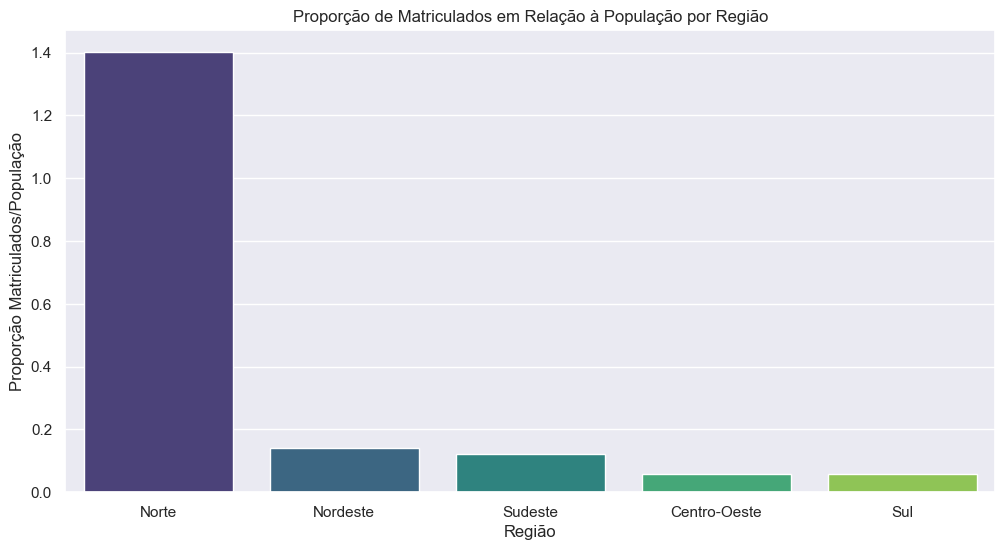

In [30]:
t3['prop_matr_pop'] = (t3['NUM_MATRICULADOS']/t3['POPULACAO'])*100

# Ordenar por proporção
t3 = t3.sort_values(by='prop_matr_pop', ascending=False)

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=t3, y='prop_matr_pop', x='NO_REGIAO', palette='viridis')
plt.xlabel('Região')
plt.ylabel('Proporção Matriculados/População')
plt.title('Proporção de Matriculados em Relação à População por Região')
plt.show()

C:\Users\giluc\AppData\Local\Temp\ipykernel_2472\3695786817.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=t3, y='prop_vagas_pop', x='NO_REGIAO', palette='viridis')


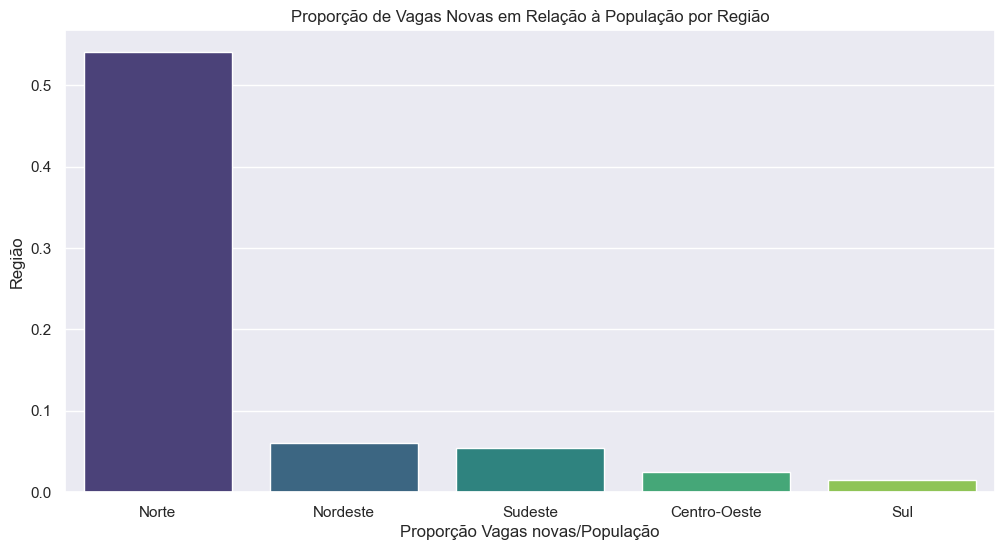

In [31]:
t3['prop_vagas_pop'] = (t3['NUM_VAGAS_ANO']/t3['POPULACAO'])*100

# Ordenar por proporção
t3 = t3.sort_values(by='prop_vagas_pop', ascending=False)

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=t3, y='prop_vagas_pop', x='NO_REGIAO', palette='viridis')
plt.xlabel('Proporção Vagas novas/População')
plt.ylabel('Região')
plt.title('Proporção de Vagas Novas em Relação à População por Região')
plt.show()

Verificar em quantas regiões intermediárias possuem IFES

In [32]:

t4 = df_cursos_ies_ibge[['CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA','CO_CURSO','QT_VG_NOVA','QT_MAT','POPULACAO', 'CO_IES']]\
    .groupby(['CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA'])\
        .agg({'CO_CURSO':'count', 'QT_VG_NOVA':'sum', 'QT_MAT':'sum', 'CO_IES':'nunique'}).reset_index()

t4.sort_values('CO_REGIAO_INTERMEDIARIA').head(10)


#t2[['CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA','CO_CURSO','QT_VG_NOVA','QT_MAT','POPULACAO']]\
#    .groupby(['CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA'])\
#        .agg({'CO_CURSO':'sum', 'QT_VG_NOVA':'sum', 'QT_MAT':'sum', 'POPULACAO':'sum'}).reset_index()

,CO_REGIAO_INTERMEDIARIA,NO_REGIAO_INTERMEDIARIA,CO_CURSO,QT_VG_NOVA,QT_MAT,CO_IES
0,1101,Porto Velho,3107,20999,48897,74
1,1102,Ji-Paraná,3599,17188,36588,52
2,1201,Rio Branco,2037,14132,30000,54
3,1202,Cruzeiro do Sul,901,820,8916,26
4,1301,Manaus,4015,89528,150119,106
5,1302,Tefé,720,1221,9185,27
6,1303,Lábrea,659,300,5810,23
7,1304,Parintins,1042,2227,13762,39
8,1401,Boa Vista,1392,10104,28892,51
9,1402,Rorainópolis - Caracaraí,378,95,2017,14


In [33]:

#df_micro_reg.head()
t5 = df_micro_reg[['uf', 'nome_estado','regiao','CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA','POPULACAO']].\
    groupby(['uf', 'nome_estado','regiao','CO_REGIAO_INTERMEDIARIA','NO_REGIAO_INTERMEDIARIA']).agg({'POPULACAO':'sum'}).reset_index()
t5.sort_values('CO_REGIAO_INTERMEDIARIA').head(10)


,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,NO_REGIAO_INTERMEDIARIA,POPULACAO
98,RO,Rondônia,Norte,1101,Porto Velho,855403
99,RO,Rondônia,Norte,1102,Ji-Paraná,760976
0,AC,Acre,Norte,1201,Rio Branco,583448
1,AC,Acre,Norte,1202,Cruzeiro do Sul,246332
4,AM,Amazonas,Norte,1301,Manaus,1430753
5,AM,Amazonas,Norte,1302,Tefé,1553963
6,AM,Amazonas,Norte,1303,Lábrea,731363
7,AM,Amazonas,Norte,1304,Parintins,1149442
100,RR,Roraima,Norte,1401,Boa Vista,1291434
101,RR,Roraima,Norte,1402,Rorainópolis - Caracaraí,880956


In [34]:
t5 = t5.merge(t4, how = 'left', left_on='CO_REGIAO_INTERMEDIARIA', right_on= 'CO_REGIAO_INTERMEDIARIA')
t5.sort_values('CO_REGIAO_INTERMEDIARIA').head(10)


,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,NO_REGIAO_INTERMEDIARIA_x,POPULACAO,NO_REGIAO_INTERMEDIARIA_y,CO_CURSO,QT_VG_NOVA,QT_MAT,CO_IES
98,RO,Rondônia,Norte,1101,Porto Velho,855403,Porto Velho,3107,20999,48897,74
99,RO,Rondônia,Norte,1102,Ji-Paraná,760976,Ji-Paraná,3599,17188,36588,52
0,AC,Acre,Norte,1201,Rio Branco,583448,Rio Branco,2037,14132,30000,54
1,AC,Acre,Norte,1202,Cruzeiro do Sul,246332,Cruzeiro do Sul,901,820,8916,26
4,AM,Amazonas,Norte,1301,Manaus,1430753,Manaus,4015,89528,150119,106
5,AM,Amazonas,Norte,1302,Tefé,1553963,Tefé,720,1221,9185,27
6,AM,Amazonas,Norte,1303,Lábrea,731363,Lábrea,659,300,5810,23
7,AM,Amazonas,Norte,1304,Parintins,1149442,Parintins,1042,2227,13762,39
100,RR,Roraima,Norte,1401,Boa Vista,1291434,Boa Vista,1392,10104,28892,51
101,RR,Roraima,Norte,1402,Rorainópolis - Caracaraí,880956,Rorainópolis - Caracaraí,378,95,2017,14


In [97]:

t5
#t5.groupby(['regiao', 'nome_estado']).agg({'CO_REGIAO_INTERMEDIARIA':'count','CO_CURSO':'sum', 'QT_VG_NOVA':'sum', 'QT_MAT':'sum', 'POPULACAO_x':'sum' })


,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,NO_REGIAO_INTERMEDIARIA_x,POPULACAO,NO_REGIAO_INTERMEDIARIA_y,CO_CURSO,QT_VG_NOVA,QT_MAT,CO_IES
0,AC,Acre,Norte,1201,Rio Branco,583448,Rio Branco,70.00,2240.00,7803.00,3.00
1,AC,Acre,Norte,1202,Cruzeiro do Sul,246332,Cruzeiro do Sul,24.00,720.00,2465.00,3.00
2,AL,Alagoas,Nordeste,2701,Maceió,88560952,Maceió,108.00,5013.00,21483.00,3.00
3,AL,Alagoas,Nordeste,2702,Arapiraca,85076300,Arapiraca,66.00,1530.00,7007.00,3.00
4,AM,Amazonas,Norte,1301,Manaus,1430753,Manaus,105.00,4918.00,25923.00,4.00
5,AM,Amazonas,Norte,1302,Tefé,1553963,Tefé,7.00,300.00,1379.00,2.00
6,AM,Amazonas,Norte,1303,Lábrea,731363,Lábrea,7.00,300.00,1167.00,2.00
7,AM,Amazonas,Norte,1304,Parintins,1149442,Parintins,18.00,780.00,3877.00,2.00
8,AP,Amapá,Norte,1601,Macapá,1838956,Macapá,72.00,2052.00,12747.00,2.00
9,AP,Amapá,Norte,1602,Oiapoque - Porto Grande,3030260,Oiapoque - Porto Grande,18.00,229.00,1286.00,2.00


In [35]:
t5['NO_REGIAO_INTERMEDIARIA_x'] = t5['regiao'] + ' (' + t5['nome_estado'] + ')' + ' - ' + t5['NO_REGIAO_INTERMEDIARIA_x'] 
t5.head(10)

,uf,nome_estado,regiao,CO_REGIAO_INTERMEDIARIA,NO_REGIAO_INTERMEDIARIA_x,POPULACAO,NO_REGIAO_INTERMEDIARIA_y,CO_CURSO,QT_VG_NOVA,QT_MAT,CO_IES
0,AC,Acre,Norte,1201,Norte (Acre) - Rio Branco,583448,Rio Branco,2037,14132,30000,54
1,AC,Acre,Norte,1202,Norte (Acre) - Cruzeiro do Sul,246332,Cruzeiro do Sul,901,820,8916,26
2,AL,Alagoas,Nordeste,2701,Nordeste (Alagoas) - Maceió,88560952,Maceió,3154,33682,77709,85
3,AL,Alagoas,Nordeste,2702,Nordeste (Alagoas) - Arapiraca,85076300,Arapiraca,2403,10029,34511,57
4,AM,Amazonas,Norte,1301,Norte (Amazonas) - Manaus,1430753,Manaus,4015,89528,150119,106
5,AM,Amazonas,Norte,1302,Norte (Amazonas) - Tefé,1553963,Tefé,720,1221,9185,27
6,AM,Amazonas,Norte,1303,Norte (Amazonas) - Lábrea,731363,Lábrea,659,300,5810,23
7,AM,Amazonas,Norte,1304,Norte (Amazonas) - Parintins,1149442,Parintins,1042,2227,13762,39
8,AP,Amapá,Norte,1601,Norte (Amapá) - Macapá,1838956,Macapá,1940,14240,47449,54
9,AP,Amapá,Norte,1602,Norte (Amapá) - Oiapoque - Porto Grande,3030260,Oiapoque - Porto Grande,205,229,1805,8


C:\Users\giluc\AppData\Local\Temp\ipykernel_12068\3405211.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=t5[t5['prop_matr_pop'] < 0.1 ], y='prop_matr_pop', x='NO_REGIAO_INTERMEDIARIA_x', palette='viridis')


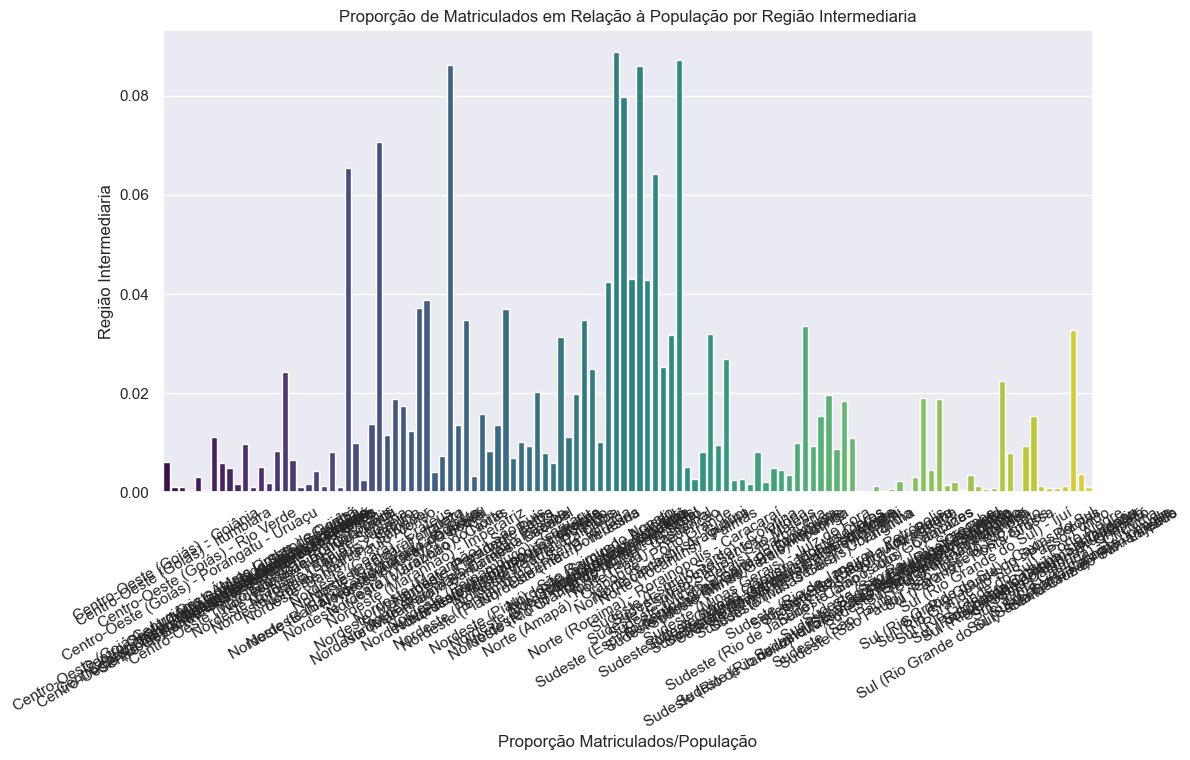

In [108]:
t5['prop_matr_pop'] = (t5['QT_MAT']*100/t5['POPULACAO'])

# Ordenar por proporção
t5 = t5.sort_values(by='NO_REGIAO_INTERMEDIARIA_x')

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=t5[t5['prop_matr_pop'] < 0.1 ], y='prop_matr_pop', x='NO_REGIAO_INTERMEDIARIA_x', palette='viridis')
plt.xlabel('Proporção Matriculados/População')
plt.ylabel('Região Intermediaria')
plt.title('Proporção de Matriculados em Relação à População por Região Intermediaria')
plt.xticks(rotation=30)
plt.show()